In [1]:
import os

In [2]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import cityscapes_labels
import utils

from models import *
from keras import losses, metrics, optimizers
from loss import precision, dice_coef


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
!nvidia-smi

Mon Feb  5 10:13:00 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970     Off  | 00000000:01:00.0  On |                  N/A |
| 53%   52C    P2   117W / 250W |   3935MiB /  4034MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
#target_height, target_width = 360, 480
#target_height, target_width = 360, 648
target_height, target_width = 384, 640

labels = cityscapes_labels.labels
n_classes = len(labels)
batch_size = 2
epochs = 10

dataset_path = '/home/xmlyna06/data/gta/'

images_path = os.path.join(dataset_path, 'images/')
labels_path = os.path.join(dataset_path, 'labels/')

# segnet
model = MobileUNet((target_height, target_width), n_classes)


#model.k.load_weights('weights/SegNet_2018_02_02_11:44_(200)_finished.h5')
model.k.load_weights('weights/MobileUNet_2018_02_05_09:02_(200)_finished.h5')

model.summary()

model.k.compile(
    loss=losses.categorical_crossentropy,
    optimizer=optimizers.Adam(lr=0.001),
    metrics=[
        dice_coef,
        precision,
        metrics.categorical_accuracy
    ]
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 384, 640, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 192, 320, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
conv_0_bn (BatchNormalization)  (None, 192, 320, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
conv_0_relu (Activation)        (None, 192, 320, 32) 0           conv_0_bn[0][0]                  
__________________________________________________________________________________________________
conv_dw_1 

In [8]:
!ls weights

2018_01_21_14:24__100_finished.h5
2018_01_21_14:44_200_finished.h5
2018_01_21_18:20_200_finished.h5
2018_01_22_08:15_200_finished.h5
mobile_unet_2018_01_21_14:44.hdf5
mobile_unet_2018_02_05_09:02.hdf5
segnet_2018_01_21_12:19__01-0.58.hdf5
segnet_2018_01_21_15:57.hdf5
segnet_2018_01_21_18:20.hdf5
segnet_2018_01_22_08:15.hdf5
segnet_2018_01_27_18:27.hdf5
segnet_2018_01_28_13:15.hdf5
segnet_2018_01_29_08:09.hdf5
segnet_2018_01_29_20:36.hdf5
SegNet_2018_02_02_11:44_(200)_finished.h5
segnet_2018_02_02_11:44.hdf5
weights__100-0.93.hdf5


(0, '/home/xmlyna06/data/gta/images/00003.png')
(1052, 1914, 3)
1/1 [==============================] - 3s 3s/step
(1, '/home/xmlyna06/data/gta/images/00005.png')
(1052, 1914, 3)
1/1 [==============================] - 3s 3s/step
(2, '/home/xmlyna06/data/gta/images/00008.png')
(1052, 1914, 3)
1/1 [==============================] - 3s 3s/step


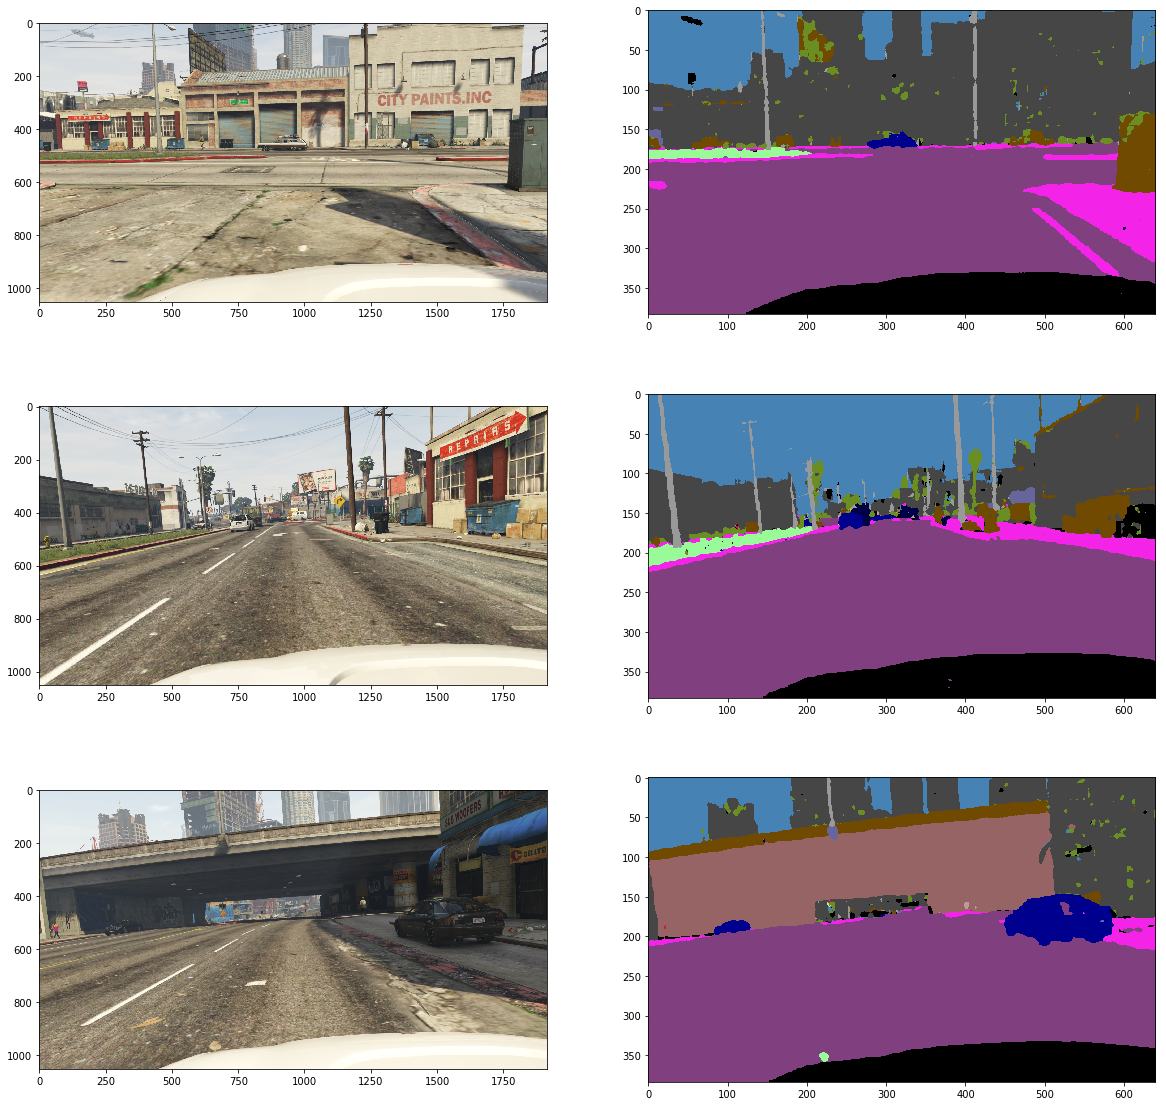

In [10]:
import data_generator
import cityscapes_labels

# testing set!
#predict_filenames = [
#    images_path + '00001.png',
#    images_path + '22001.png',
#    './results/cityscapes_2_img.png',
#    './results/exp1_camvid.png',
#    './results/img_aachen_000007_000019_leftImg8bit.png.png'
#]
#

predict_filenames = [
     images_path + '00003.png',
     images_path + '00005.png',
     images_path + '00008.png',
]

f, arr= plt.subplots(len(predict_filenames),2)
f.set_size_inches(20,20)

for i, filename in enumerate(predict_filenames):
    print(i, filename)

    image = cv2.imread(filename)

    print(image.shape)

    norm = data_generator.SimpleSegmentationGenerator.normalize(image, (target_height,target_width))

    prediction = model.k.predict(np.array([norm]), batch_size, verbose=1)

    class_scores = prediction.reshape((target_height, target_width, n_classes))
    class_image = np.argmax(class_scores, axis=2)
    colored_class_image = utils.class_image_to_image(class_image, cityscapes_labels.trainId2label)  # there should be trainid2label

    predicting_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    arr[i][0].imshow(predicting_image)
    arr[i][1].imshow(colored_class_image)

    im_to_save = cv2.cvtColor(colored_class_image, cv2.COLOR_RGB2BGR)

    cv2.imwrite('results/img_'+str(filename.split('/')[-1])+'.png', image)
    cv2.imwrite('results/pred_'+ str(filename.split('/')[-1])+'.png', im_to_save)

(0, '../gta_input.png')
(1052, 1914, 3)
1/1 [==============================] - 6s 6s/step
(1, '../camvid_input.png')
(720, 960, 3)
1/1 [==============================] - 6s 6s/step


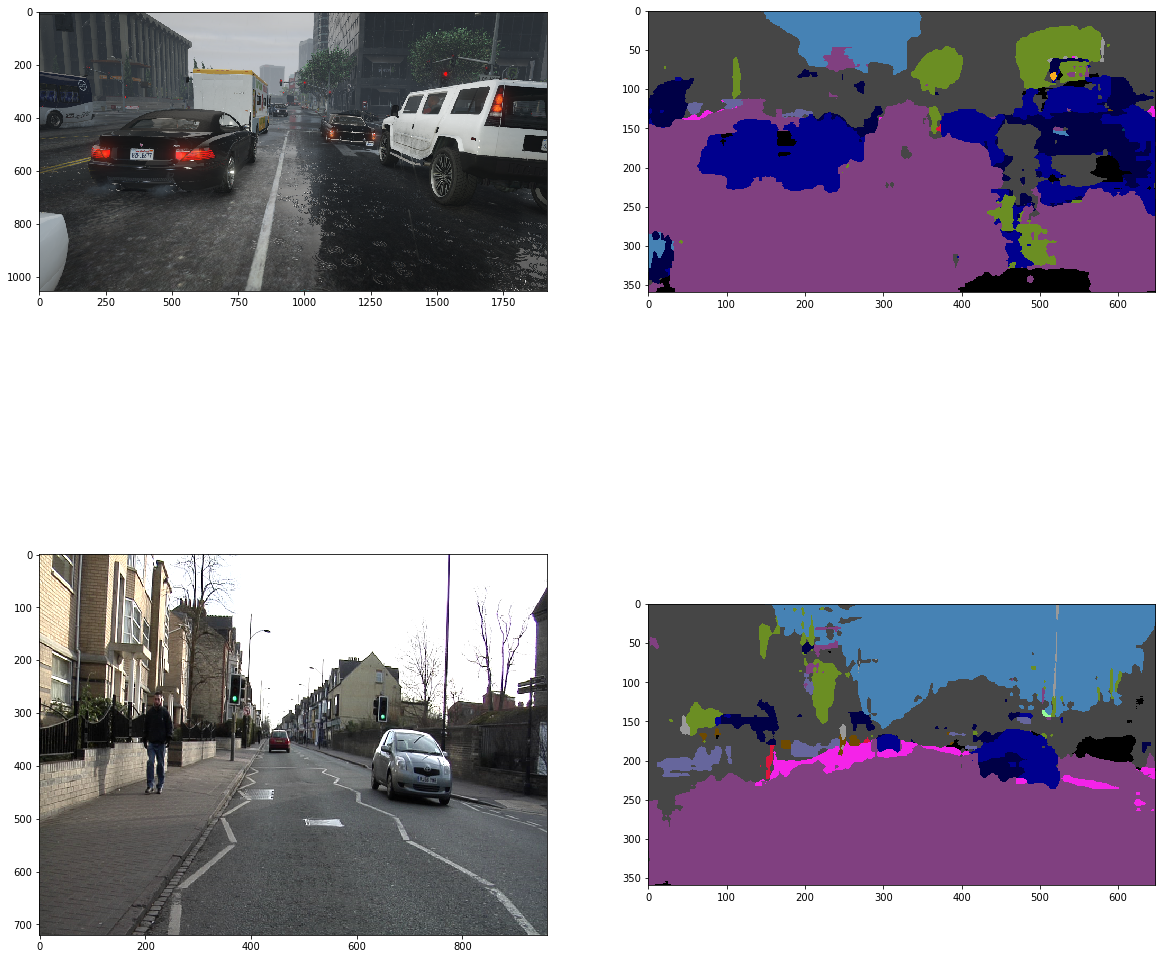

(1052, 1914, 3)
1/1 [==============================] - 9s 9s/step


True

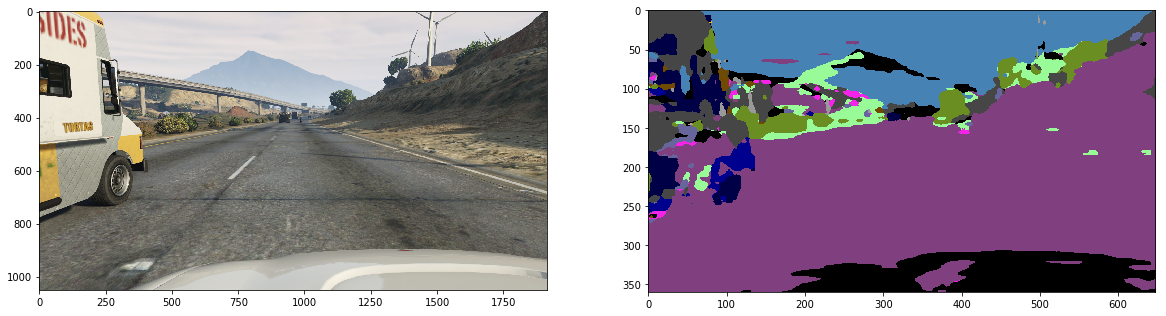

True

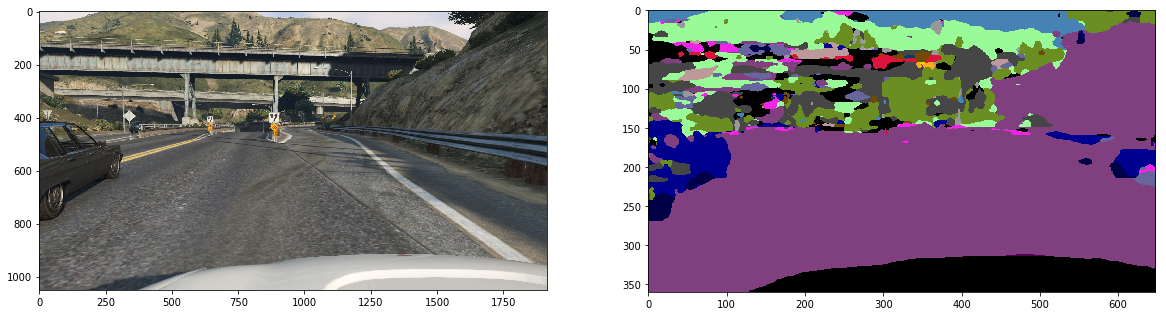

In [44]:
!pwd

/home/xmlyna06/cnn-segmentation/gta_segnet


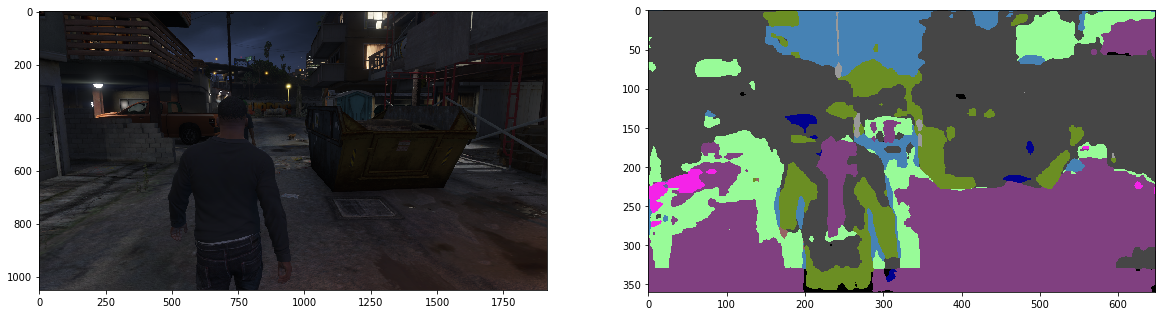